Goal: Build a morphology pipeline (threshold → opening → closing) on a noisy image.
I want to see how opening removes small noise and how closing fills small gaps in objects.

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Helper functions

# Show as inline with matplotlib (avoids cv2.imshow issues)
def show(img, title="image", cmap='gray'):
    plt.figure(figsize=(4, 4))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        # convert BGR -> RGB for correct colors
        img_rgb = cv2.cvtColor(img, cv.COLOR_BGR2RGB)        
        plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

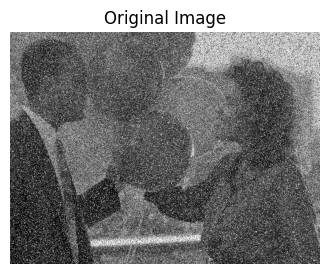

In [3]:
# Example image
img_path = r'D:/Python things/middle-ml-cv-roadmap/data/raw/img_example_3_noisy_foreground.jpg'
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
# img = cv.imread(img_path)
show(img, 'Original Image')

The image is heavily afflicted with digital noise but appears to depict two people—one in a dark suit on the left and one on the right holding a cluster of balloons.

First, let's try to reduce the noise observed in the image.

For this task I used Median blur filter, as there are strong "salt-and-pepper" noise and this filter had showing better result.
I apllied Median blur filter for several times in a row with the relatively small ksize for the same image as such approach showed better result.
Perhaps, that isn't the most efficient way, but for curent stage the efficiency ist't the primary goal.

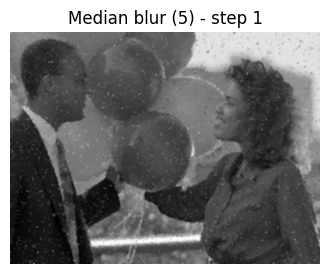

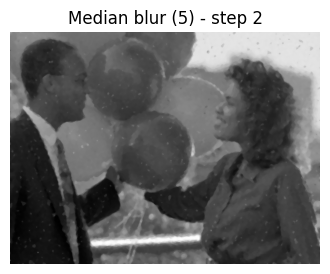

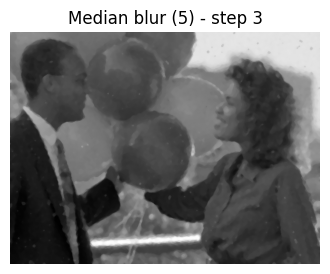

In [4]:
ksize = 5
steps = 3

noiseless_img = img
for step in range(steps):
    noiseless_img = cv.medianBlur(noiseless_img, ksize=ksize)
    show(noiseless_img, f"Median blur ({ksize}) - step {step + 1}")

For creation a binary image from a grayscale image I used Otsu’s thresholding as lighting is relatively uniform and I don’t know threshold.

The result: small noise spots remain, but the boundaries look quite clear, although the outlines of some objects are partially lost.

Otsu threshold: 99.0


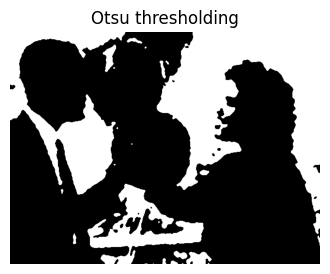

In [5]:
# Otsu’s thresholding
ret, th_otsu = cv.threshold(
    noiseless_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
print("Otsu threshold:", ret)
show(th_otsu, "Otsu thresholding")

There are some white dots, so opening may improve the result a little.

Closing is unlikely to be useful, but for the sake of experimenting and consolidating knowledge, I conducted it also.

I used a simple square as kernel, as more advanced techniques didn't show significant improvement.

In [6]:
# Structuring element (kernel)
kernel = np.ones((5, 5), np.uint8)   # simple 3x3 square
# more advanced:
# kernel_rect = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
# kernel_ellipse = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

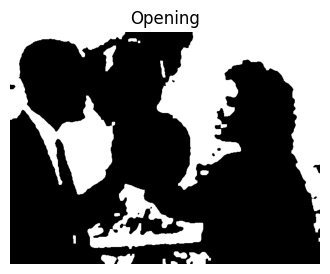

In [7]:
# Opening (erode → dilate)
opened = cv.morphologyEx(th_otsu, cv.MORPH_OPEN, kernel)
show(opened, "Opening")

In [8]:
white_before = (th_otsu == 255).sum()
white_after_open = (opened == 255).sum()
white_dots_change = round(white_after_open / white_before - 1, 4)
print(f'White dots changing after opening - {white_dots_change}')

White dots changing after opening - -0.0098


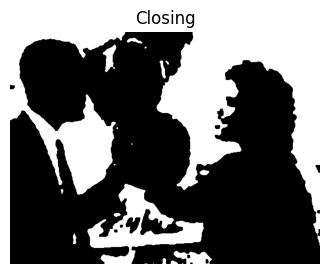

In [9]:
# Closing (dilate → erode)
closed = cv.morphologyEx(th_otsu, cv.MORPH_CLOSE, kernel)

show(closed, "Closing")

In [10]:
white_before = (th_otsu == 255).sum()
white_after_close = (closed == 255).sum()
white_dots_change = round(white_after_close / white_before - 1, 4)
print(f'White dots changing after closing - {white_dots_change}')

White dots changing after closing - 0.0076


Opening removed small portion of white pixels (~0.2%), mostly small isolated dots, as closing slightly filled small black holes (increased white pixels by ~0.1%), But both morphological operations didn't show significant imrpovenet in this case.

Kernel size strongly affects the result: with a 3×3 kernel only very small noise disappears; with 7×7 larger parts of shapes are also affected.